Completed Testing

import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys

from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, recall_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'new image frames.xlsx')
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=f'{video_folder}')
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                        frame_idx = int(root.split('_')[-1]) #splitting xxx_0 and storing 0 to frame_idx
                        labels = labels_df.loc[frame_idx, ['CORD', 'FLUID']].values.astype('float32').squeeze()

                        #print(img_path)
                        #print(labels)

                        self.image_paths.append(img_path)
                        self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['CORD','FLUID']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, labels


# Initialize Dataset and Dataloader
def initialize_data(root_dir, sub_folder, data_type='original'):
    # Define image transformations
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),])
    train_dataset = CustomDataset(root_dir, sub_folder = sub_folder, transform=transform, data_type=data_type)

    # Define the sizes for training, validation, and test sets
    total_size = len(train_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset
    # torch.cuda.manual_seed_all(0)  # Setting the random seed
    train_subset, val_subset, test_subset = random_split(train_dataset, [train_size, val_size, test_size])

    # Create data loaders for each subset
    batch_size = 64
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    print('Data Size: train:',len(train_loader.dataset),'val:',len(val_loader.dataset),'test:',len(test_loader.dataset))

    return train_loader, val_loader, test_loader

In [3]:
# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

In [4]:
# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})
            torch.save(model, "saved_model.pt")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the state of the model
        torch.save(model.state_dict(), "saved_model_state.pt")
        torch.save(model, "saved_model.pt")

        ######################### Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [5]:
# Load Model
def load_model(model_path):
    # Load the saved model
    model = torch.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

In [6]:
# Test Model
def test_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            #Check for misclassifications
            for idx, (pred, true) in enumerate(zip(predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
      y_true = np.array(all_labels)[:, i]
      y_pred = np.array(all_preds)[:, i]

      precision = precision_score(y_true, y_pred, zero_division=0)
      recall = recall_score(y_true, y_pred, zero_division=0)
      f1 = f1_score(y_true, y_pred, zero_division=0)

      # Only calculate ROC AUC if both classes (0 and 1) are present in y_true
      if len(np.unique(y_true)) > 1:
          roc_auc = roc_auc_score(y_true, y_pred)
      else:
          roc_auc = float('nan')  # or you can set this to 0, or any other default value

      tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

      class_precisions.append(precision)
      class_recalls.append(recall)
      class_f1s.append(f1)
      class_roc_aucs.append(roc_auc)

      print(f"Metrics for class {i}:")
      print(f"  Precision : {precision:.4f}")
      print(f"  Recall    : {recall:.4f}")
      print(f"  F1 Score  : {f1:.4f}")
      print(f"  ROC AUC   : {roc_auc:.4f}")
      print(f'True Negatives : {tn}')
      print(f'False Positives: {fp}')
      print(f'False Negatives: {fn}')
      print(f'True Positives : {tp}')
      print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [7]:
# Main function to run the whole pipeline
def main(root_dir, sub_folder, model, criterion, optimizer, num_epochs, data_type='original'):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder, data_type=data_type)
    #check_loaders(train_loader, val_loader, test_loader)

    '''global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds = test_model(test_loader, model, criterion)


In [8]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axs[i].axis('off')
        if labels is not None:
            axs[i].set_title(labels[i])

def check_loaders(train_loader, val_loader, test_loader):
    print("Train Loader: {} batches ({} images)".format(len(train_loader), len(train_loader.dataset)))
    print("Validation Loader: {} batches ({} images)".format(len(val_loader), len(val_loader.dataset)))
    print("Test Loader: {} batches ({} images)".format(len(test_loader), len(test_loader.dataset)))

    # Optionally, visualize some images from each loader
    for images, labels in train_loader:
        show_images(images)
        break  # Just show the first batch

In [9]:
#train-valid-test
def tvt(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds = test_model(test_loader, model, criterion)


In [10]:
root_dir = '/content/drive/MyDrive/Fall 2024 Classes/Capstone: CV for Infant Lumbar Puncture/Data Files'    # CHANGE BASED ON FOLDER LOCATION
sub_folder = 'New Video Frames'
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
org_train_loader, org_val_loader, org_test_loader = initialize_data(root_dir,
                                                                    sub_folder,
                                                                    data_type='original')

Processing video folder: 200106061016030017SMP_crop
Processing video folder: 200106061016340018SMP_crop
Processing video folder: 200106061016530019SMP_crop
Processing video folder: 200106061017230020SMP_crop
Processing video folder: 202402091355160039ABD_crop
Processing video folder: 202402091355230040ABD_crop
Processing video folder: 202402091355350041ABD_crop
Processing video folder: 202402091355470042ABD_crop
Processing video folder: 202402091355560043ABD_crop
Processing video folder: 202402091356080044ABD_cropCONUS
Processing video folder: 202402091356160045ABD_crop
Processing video folder: 202402091356410046ABD_crop
Processing video folder: 202402091356500047ABD_crop
Processing video folder: 202402091356590048ABD_crop
Number of videos: 14
Data Size: train: 476 val: 68 test: 137


In [11]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

Epoch 1: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, Batch Loss=0.012, Batch Accuracy=1]


Epoch 1/20 - Loss: 0.1842, Accuracy: 0.9086
Validation:


Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s, Batch Loss=0.0145, Batch Accuracy=1]


Validation Epoch 1/20 - Loss: 0.0326, Accuracy: 0.9926
------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, Batch Loss=0.00424, Batch Accuracy=1]


Epoch 2/20 - Loss: 0.0046, Accuracy: 1.0000
Validation:


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s, Batch Loss=0.00241, Batch Accuracy=1]


Validation Epoch 2/20 - Loss: 0.0184, Accuracy: 0.9926
------------------------------------------------------------------------------------------------


Epoch 3: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s, Batch Loss=0.00122, Batch Accuracy=1]


Epoch 3/20 - Loss: 0.0016, Accuracy: 1.0000
Validation:


Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s, Batch Loss=0.00143, Batch Accuracy=1]


Validation Epoch 3/20 - Loss: 0.0017, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s, Batch Loss=0.000708, Batch Accuracy=1]


Epoch 4/20 - Loss: 0.0008, Accuracy: 1.0000
Validation:


Epoch 4: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s, Batch Loss=0.000979, Batch Accuracy=1]


Validation Epoch 4/20 - Loss: 0.0008, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 5: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s, Batch Loss=0.000564, Batch Accuracy=1]


Epoch 5/20 - Loss: 0.0006, Accuracy: 1.0000
Validation:


Epoch 5: 100%|██████████| 3/3 [00:00<00:00,  4.73it/s, Batch Loss=0.000779, Batch Accuracy=1]


Validation Epoch 5/20 - Loss: 0.0006, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 6: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s, Batch Loss=0.000791, Batch Accuracy=1]


Epoch 6/20 - Loss: 0.0006, Accuracy: 1.0000
Validation:


Epoch 6: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s, Batch Loss=0.000595, Batch Accuracy=1]


Validation Epoch 6/20 - Loss: 0.0005, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 7: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s, Batch Loss=0.0361, Batch Accuracy=0.982]


Epoch 7/20 - Loss: 0.0031, Accuracy: 0.9989
Validation:


Epoch 7: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s, Batch Loss=0.000199, Batch Accuracy=1]


Validation Epoch 7/20 - Loss: 0.0013, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, Batch Loss=0.00269, Batch Accuracy=1]


Epoch 8/20 - Loss: 0.0147, Accuracy: 0.9958
Validation:


Epoch 8: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, Batch Loss=0.273, Batch Accuracy=0.875]


Validation Epoch 8/20 - Loss: 0.2730, Accuracy: 0.8676
------------------------------------------------------------------------------------------------


Epoch 9: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, Batch Loss=0.00138, Batch Accuracy=1]


Epoch 9/20 - Loss: 0.0019, Accuracy: 1.0000
Validation:


Epoch 9: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s, Batch Loss=0.000592, Batch Accuracy=1]


Validation Epoch 9/20 - Loss: 0.0007, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 10: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, Batch Loss=0.00229, Batch Accuracy=1]


Epoch 10/20 - Loss: 0.0016, Accuracy: 1.0000
Validation:


Epoch 10: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s, Batch Loss=0.00103, Batch Accuracy=1]


Validation Epoch 10/20 - Loss: 0.0006, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 11: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s, Batch Loss=0.000738, Batch Accuracy=1]


Epoch 11/20 - Loss: 0.0008, Accuracy: 1.0000
Validation:


Epoch 11: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s, Batch Loss=0.000639, Batch Accuracy=1]


Validation Epoch 11/20 - Loss: 0.0004, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 12: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s, Batch Loss=0.000266, Batch Accuracy=1]


Epoch 12/20 - Loss: 0.0004, Accuracy: 1.0000
Validation:


Epoch 12: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s, Batch Loss=0.000421, Batch Accuracy=1]


Validation Epoch 12/20 - Loss: 0.0003, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 13: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s, Batch Loss=0.000246, Batch Accuracy=1]


Epoch 13/20 - Loss: 0.0003, Accuracy: 1.0000
Validation:


Epoch 13: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s, Batch Loss=0.000332, Batch Accuracy=1]


Validation Epoch 13/20 - Loss: 0.0003, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 14: 100%|██████████| 15/15 [00:09<00:00,  1.63it/s, Batch Loss=0.000233, Batch Accuracy=1]


Epoch 14/20 - Loss: 0.0004, Accuracy: 1.0000
Validation:


Epoch 14: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s, Batch Loss=0.000291, Batch Accuracy=1]


Validation Epoch 14/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 15: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s, Batch Loss=0.000214, Batch Accuracy=1]


Epoch 15/20 - Loss: 0.0003, Accuracy: 1.0000
Validation:


Epoch 15: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s, Batch Loss=0.000234, Batch Accuracy=1]


Validation Epoch 15/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 16: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s, Batch Loss=0.000456, Batch Accuracy=1]


Epoch 16/20 - Loss: 0.0003, Accuracy: 1.0000
Validation:


Epoch 16: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s, Batch Loss=0.000211, Batch Accuracy=1]


Validation Epoch 16/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 17: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s, Batch Loss=0.000174, Batch Accuracy=1]


Epoch 17/20 - Loss: 0.0002, Accuracy: 1.0000
Validation:


Epoch 17: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s, Batch Loss=0.000198, Batch Accuracy=1]


Validation Epoch 17/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 18: 100%|██████████| 15/15 [00:09<00:00,  1.67it/s, Batch Loss=0.000254, Batch Accuracy=1]


Epoch 18/20 - Loss: 0.0002, Accuracy: 1.0000
Validation:


Epoch 18: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s, Batch Loss=0.000168, Batch Accuracy=1]


Validation Epoch 18/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 19: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s, Batch Loss=0.000256, Batch Accuracy=1]


Epoch 19/20 - Loss: 0.0002, Accuracy: 1.0000
Validation:


Epoch 19: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s, Batch Loss=0.000165, Batch Accuracy=1]


Validation Epoch 19/20 - Loss: 0.0002, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


Epoch 20: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s, Batch Loss=0.000148, Batch Accuracy=1]


Epoch 20/20 - Loss: 0.0002, Accuracy: 1.0000
Validation:


Epoch 20: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s, Batch Loss=0.000155, Batch Accuracy=1]


Validation Epoch 20/20 - Loss: 0.0001, Accuracy: 1.0000
------------------------------------------------------------------------------------------------


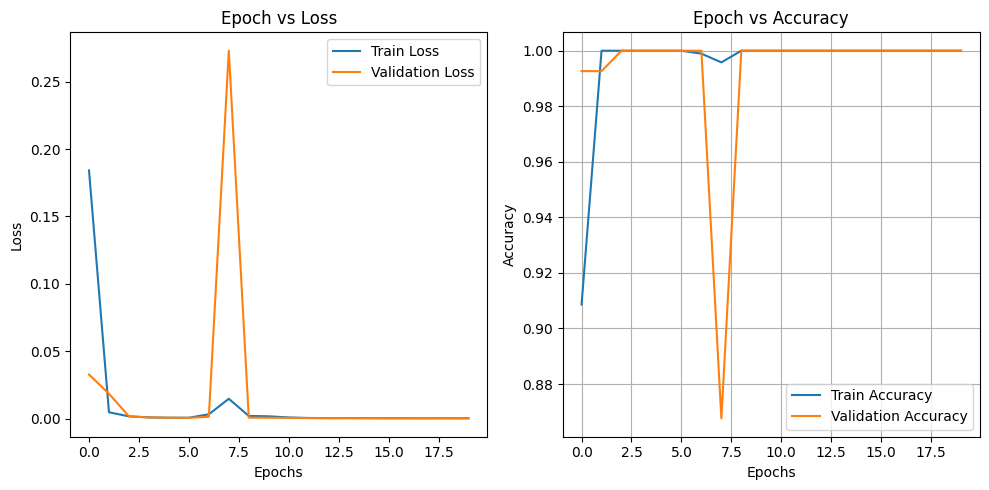

<ipython-input-5-ae76e8f17af0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


AttributeError: 'CustomResNet' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [12]:
if __name__ == "__main__":
    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Model, Loss, and Optimizer
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Run the main function
    tvt(org_train_loader, org_val_loader, org_test_loader, model, criterion, optimizer, num_epochs=20)

In [13]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(org_test_loader, "saved_model.pt", criterion)

<ipython-input-5-ae76e8f17af0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s, Batch L


Test Metrics:
--------------------------------------------------
Loss      : 0.0001
Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
True Negatives : 73
False Positives: 0
False Negatives: 0
True Positives : 201
F1 Score  : 1.0000
ROC AUC   : 1.0000
Metrics for class 0:
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000
True Negatives : 73
False Positives: 0
False Negatives: 0
True Positives : 64
--------------------



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
# Test Model
def test_miss_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            # Check for misclassifications
            for idx, (img, pred, true) in enumerate(zip(images, predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,  # Store the index
                        'image': img.cpu(),  # Store the image tensor
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [ ]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_miss_model(org_test_loader, "saved_model.pt", criterion)

In [ ]:
#function for all missclassified images

import matplotlib.pyplot as plt
import math

def show_misclassified_images(misclassified_images):
    num_images = len(misclassified_images)
    num_cols = 5  # You can adjust the number of columns
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i in range(num_images):
        img_info = misclassified_images[i]
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        index = img_info['image_index']  # Get the image index

        ax = axs[i // num_cols, i % num_cols]  # Determine row and column position
        ax.imshow(img)
        ax.set_title(f"Index: {index}\nPred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for i in range(num_images, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()


In [ ]:
# Now display the misclassified images
show_misclassified_images(misclassified_images)

In [ ]:
#calling all misclassified images

show_misclassified_images(misclassified_images)

In [ ]:
def calculate_fp_fn(misclassified_images, num_classes):
    # Initialize counters
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    # Analyze each misclassified image
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        true_labels = img_info['true_labels']

        for i in range(num_classes):
            # False positive: predicted is 1, true is 0
            if predicted_labels[i] == 1 and true_labels[i] == 0:
                false_positives[i] += 1
            # False negative: predicted is 0, true is 1
            elif predicted_labels[i] == 0 and true_labels[i] == 1:
                false_negatives[i] += 1

    return false_positives, false_negatives

# Call this function after you have the misclassified_images list
false_positives, false_negatives = calculate_fp_fn(misclassified_images, 3)

# Print the results
print("False Positives per Class:", false_positives)
print("False Negatives per Class:", false_negatives)


False Positives per Class: [11, 0, 0]

For the first class (let's call it Class 1), your model incorrectly predicted the positive label (predicted as '1') 11 times when the true label was negative (actual '0'). This means there were 11 instances where the model thought the feature corresponding to Class 1 was present, but it actually wasn't.
For the second and third classes (Class 2 and Class 3), there were no false positives. This means the model never incorrectly predicted the presence of these features; it did not mistakenly identify these features in any of the images where they were actually absent.
False Negatives per Class: [0, 3, 10]

For Class 1, there were no false negatives. This means that whenever the feature corresponding to Class 1 was present in an image, the model always identified it correctly.
For Class 2, there were 3 instances where the model failed to identify the presence of the feature (predicted as '0') when it was actually present (true '1'). In other words, the model missed this feature 3 times when it should have detected it.
For Class 3, the situation is more pronounced with 10 false negatives. This indicates that the model frequently failed to recognize the presence of the feature corresponding to Class 3.

In [ ]:
def filter_specific_misclassifications(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        true_labels = img_info['true_labels']
        predicted_labels = img_info['predicted_labels']
        # Check if Class 1 is '1' and Class 2 & 3 are '0' in true labels
        # and if Class 1 is correctly predicted as '1'
        if true_labels[0] == 1 and true_labels[1] == 0 and true_labels[2] == 0 and predicted_labels[0] == 1:
            filtered_images.append(img_info)
    return filtered_images

specific_misclassifications = filter_specific_misclassifications(misclassified_images)

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']

        # Handle the case when axs is 1-dimensional
        if num_images <= num_cols:
            ax = axs[i]  # Index as a 1D array
        else:
            ax = axs[i // num_cols, i % num_cols]  # Index as a 2D array

        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        if num_images <= num_cols:
            axs[j].axis('off')  # Index as a 1D array
        else:
            axs[j // num_cols, j % num_cols].axis('off')  # Index as a 2D array

    plt.show()

In [ ]:
# Filter and show the specific misclassifications
show_filtered_images(specific_misclassifications)

In [ ]:
def filter_specific_predictions(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        # Check if predicted Class 1 is '1' and Classes 2 & 3 are '0'
        if predicted_labels[0] == 1 and predicted_labels[1] == 0 and predicted_labels[2] == 0:
            filtered_images.append(img_info)
    return filtered_images

specific_predictions = filter_specific_predictions(misclassified_images)

import matplotlib.pyplot as plt
import math

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    # If there's only one row, axs will be 1D, so we need to handle this case
    if num_rows == 1:
        axs = [axs]  # Make axs a list of lists

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        ax = axs[i // num_cols][i % num_cols] # Access the correct element now that axs is 2D
        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j // num_cols][j % num_cols].axis('off')  # Access correctly

    plt.show()

In [ ]:
# Filter and show the specific predictions
show_filtered_images(specific_predictions)